<a href="https://colab.research.google.com/github/MarcosRigal/CNC/blob/main/P4/P4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 4: Clasificación Semi-Supervisada

**Objetivo**: El objetivo de esta práctica es introducir los conceptos de clasificación semi-supervisada.

La práctica consiste en dos tareas:

## TAREA 1: Implementación de un método
- Seleccione un algoritmo de los indicados en la teoría que implemente aprendizaje semi-supervisado de cualquiera de los paradigmas estudiados.
- Implemente el algoritmo.
- Seleccione al menos un dataset semi-supervisado y evalúe el algoritmo implementado.

## TAREA 2: Comparación de métodos
1. Seleccione al menos dos algoritmos de los disponibles en las bibliotecas indicadas.
2. Seleccione al menos tres problemas semi-supervisados de los repositorios indicados.
3. Aplique los algoritmos seleccionados a los datasets.
4. Compare los resultados y explique las conclusiones obtenidas.


# TAREA 1: Implementación de un método de Self-Training
En esta sección se muestra la implementación propia de un algoritmo de **Self-Training** y su posterior evaluación en un dataset sintético.

In [43]:
import numpy as np
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

def self_training(X_labeled, y_labeled, X_unlabeled, base_classifier,
                  confidence_threshold=0.9, max_iter=10):
    """
    Self-Training method.

    Parameters
    ----------
    X_labeled : array-like, shape (n_labeled_samples, n_features)
        Labeled dataset.
    y_labeled : array-like, shape (n_labeled_samples,)
        Corresponding labels for X_labeled.
    X_unlabeled : array-like, shape (n_unlabeled_samples, n_features)
        Unlabeled dataset.
    base_classifier : scikit-learn estimator
        Base classifier that must support at least predict_proba.
    confidence_threshold : float, optional (default=0.9)
        Minimum probability threshold to accept pseudo-labeled instances.
    max_iter : int, optional (default=10)
        Maximum number of self-training iterations.

    Returns
    -------
    trained_classifier : scikit-learn estimator
        The trained classifier after self-training.
    """
    X_l = X_labeled.copy()
    y_l = y_labeled.copy()
    X_u = X_unlabeled.copy()

    for i in range(1, max_iter + 1):
        current_clf = clone(base_classifier)
        current_clf.fit(X_l, y_l)

        if hasattr(current_clf, "predict_proba"):
            probs = current_clf.predict_proba(X_u)
            pred_labels = np.argmax(probs, axis=1)
            max_probs = np.max(probs, axis=1)
        else:
            pred_labels = current_clf.predict(X_u)
            max_probs = np.ones(len(X_u))

        high_conf_idx = np.where(max_probs >= confidence_threshold)[0]
        if len(high_conf_idx) == 0:
            print(f"Iteración {i}: No se encontraron instancias con confianza >= {confidence_threshold}. Finalizando.")
            break

        X_l = np.vstack([X_l, X_u[high_conf_idx]])
        y_l = np.hstack([y_l, pred_labels[high_conf_idx]])
        X_u = np.delete(X_u, high_conf_idx, axis=0)

        print(f"Iteración {i}: Se añadieron {len(high_conf_idx)} instancias con alta confianza.")

        if len(X_u) == 0:
            print(f"Iteración {i}: No quedan instancias no etiquetadas. Finalizando.")
            break

    final_clf = clone(base_classifier)
    final_clf.fit(X_l, y_l)

    return final_clf

### Ejemplo de uso en un dataset real (Digits)

In [44]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Carga de un dataset real (Digits)
data = load_digits()
X, y = data.data, data.target

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Seleccionamos un porcentaje de datos etiquetados
labeled_percentage = 0.2
num_labeled = int(len(y_train) * labeled_percentage)

X_labeled = X_train[:num_labeled]
y_labeled = y_train[:num_labeled]
X_unlabeled = X_train[num_labeled:]

# Entrenamiento con RandomForestClassifier utilizando Self-Training
rf = RandomForestClassifier(n_estimators=100, random_state=42)
self_trained_model = self_training(
    X_labeled,
    y_labeled,
    X_unlabeled,
    rf,
    confidence_threshold=0.9,
    max_iter=10
)

# Evaluación en el conjunto de prueba
y_pred = self_trained_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud en test tras Self-Training:", accuracy)

Iteración 1: Se añadieron 70 instancias con alta confianza.
Iteración 2: Se añadieron 43 instancias con alta confianza.
Iteración 3: Se añadieron 18 instancias con alta confianza.
Iteración 4: Se añadieron 12 instancias con alta confianza.
Iteración 5: Se añadieron 4 instancias con alta confianza.
Iteración 6: Se añadieron 1 instancias con alta confianza.
Iteración 7: Se añadieron 4 instancias con alta confianza.
Iteración 8: Se añadieron 4 instancias con alta confianza.
Iteración 9: Se añadieron 2 instancias con alta confianza.
Iteración 10: Se añadieron 1 instancias con alta confianza.
Exactitud en test tras Self-Training: 0.9407407407407408


# TAREA 2: Comparación de métodos

En esta segunda parte, se comparan dos métodos de clasificación semi-supervisada:
- **Label Spreading**  
- **Self-Training**

Se emplean **tres datasets** de scikit-learn: *Iris*, *Wine* y *Breast Cancer*. Se enmascara un porcentaje de las etiquetas (por ejemplo, el 50%) para simular un escenario semi-supervisado y luego se entrena y evalúa cada modelo.

### Importaciones

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)
from sklearn.datasets import load_iris, load_wine, load_breast_cancer

### Carga de datasets con etiquetas ocultas

In [46]:
def load_real_datasets(mask_ratio=0.5, random_state=42):
    """
    Carga tres datasets de sklearn (Iris, Wine, Breast Cancer) y oculta una fracción (mask_ratio)
    de sus etiquetas para simular un escenario semi-supervisado.
    Retorna un diccionario con {nombre_dataset: (X, y_masked)}.
    """
    datasets = {}
    rng = np.random.default_rng(random_state)

    for name, loader in zip(["Iris", "Wine", "Breast Cancer"],
                            [load_iris, load_wine, load_breast_cancer]):
        data = loader()
        X, y = data.data, data.target
        y_masked = y.copy()

        # Índices aleatorios a los que se les quita la etiqueta
        mask = rng.choice(len(y_masked), size=int(mask_ratio * len(y_masked)), replace=False)
        y_masked[mask] = -1  # Se coloca -1 donde no hay etiqueta

        # Asegurar que todas las clases mantengan al menos una etiqueta
        while len(set(y_masked[y_masked != -1])) < len(set(y)):
            mask = rng.choice(len(y_masked), size=int(mask_ratio * len(y_masked)), replace=False)
            y_masked = y.copy()
            y_masked[mask] = -1

        datasets[name] = (X, y_masked)

    return datasets

### Función para evaluar un modelo semi-supervisado

In [47]:
def evaluate_semi_supervised(model, X, y, dataset_name):
    """
    Divide X, y en train y test; entrena 'model' y evalúa las métricas
    únicamente en las instancias del test que sí tengan etiqueta real.
    """
    # Dividir en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Entrenar
    try:
        model.fit(X_train, y_train)
    except ValueError as e:
        print(f"[ERROR] No se pudo entrenar {dataset_name} con {model.__class__.__name__}: {e}")
        return None, None, None, None

    # Filtrar muestras etiquetadas en test
    test_labeled_mask = (y_test != -1)
    X_test_labeled, y_test_labeled = X_test[test_labeled_mask], y_test[test_labeled_mask]

    if len(y_test_labeled) == 0:
        print(f"[ADVERTENCIA] No hay muestras etiquetadas en el test para {dataset_name}.")
        return None, None, None, None

    # Predicción
    try:
        y_pred = model.predict(X_test_labeled)
    except Exception as e:
        print(f"[ERROR] No se pudo predecir {dataset_name} con {model.__class__.__name__}: {e}")
        return None, None, None, None

    # Cálculo de métricas
    acc = accuracy_score(y_test_labeled, y_pred)
    f1  = f1_score(y_test_labeled, y_pred, average='macro', zero_division=1)
    prec = precision_score(y_test_labeled, y_pred, average='macro', zero_division=1)
    rec  = recall_score(y_test_labeled, y_pred, average='macro', zero_division=1)

    # Mostrar resultados
    print(f"\nResultados en {dataset_name} con {model.__class__.__name__}:")
    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test_labeled, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_test_labeled, y_pred, zero_division=1))

    # Visualización de la matriz de confusión
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test_labeled, y_pred), annot=True,
                cmap="Blues", fmt="d")
    plt.title(f"Matriz de Confusión - {dataset_name}")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.show()

    return acc, f1, prec, rec

### Entrenamiento y evaluación con Label Spreading y Self-Training


=== Iris | Label Spreading ===

Resultados en Iris con LabelSpreading:
Accuracy: 0.9545, F1-score: 0.9441, Precision: 0.9444, Recall: 0.9524
Matriz de Confusión:
[[10  0  0]
 [ 0  5  0]
 [ 0  1  6]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91         5
           2       1.00      0.86      0.92         7

    accuracy                           0.95        22
   macro avg       0.94      0.95      0.94        22
weighted avg       0.96      0.95      0.95        22



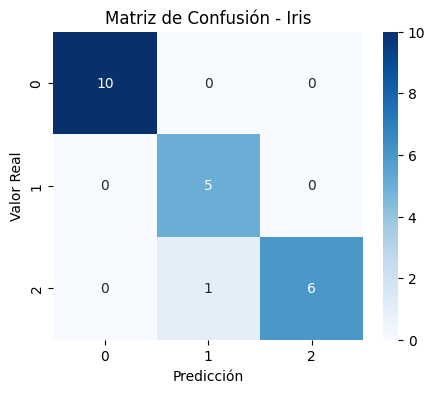


=== Iris | Self-Training ===

Resultados en Iris con SelfTrainingClassifier:
Accuracy: 1.0000, F1-score: 1.0000, Precision: 1.0000, Recall: 1.0000
Matriz de Confusión:
[[10  0  0]
 [ 0  5  0]
 [ 0  0  7]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



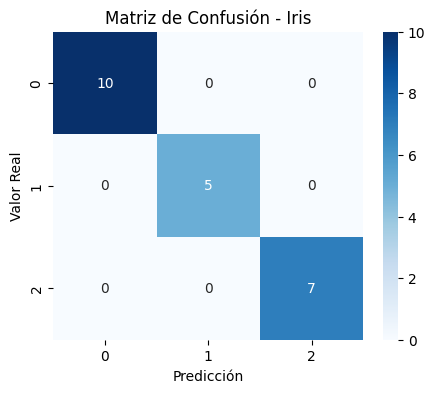


=== Wine | Label Spreading ===

Resultados en Wine con LabelSpreading:
Accuracy: 0.7083, F1-score: 0.7260, Precision: 0.7407, Recall: 0.7163
Matriz de Confusión:
[[6 0 1]
 [0 6 3]
 [0 3 5]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.67      0.67      0.67         9
           2       0.56      0.62      0.59         8

    accuracy                           0.71        24
   macro avg       0.74      0.72      0.73        24
weighted avg       0.73      0.71      0.72        24



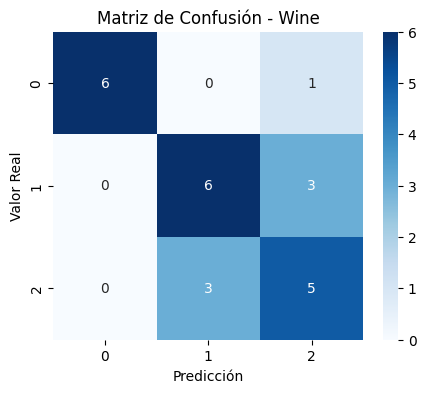


=== Wine | Self-Training ===

Resultados en Wine con SelfTrainingClassifier:
Accuracy: 0.5417, F1-score: 0.5517, Precision: 0.6667, Recall: 0.5317
Matriz de Confusión:
[[3 4 0]
 [0 6 3]
 [0 4 4]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.43      0.67      0.52         9
           2       0.57      0.50      0.53         8

    accuracy                           0.54        24
   macro avg       0.67      0.53      0.55        24
weighted avg       0.64      0.54      0.55        24



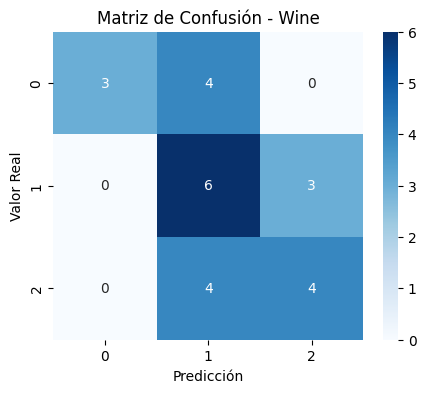


=== Breast Cancer | Label Spreading ===

Resultados en Breast Cancer con LabelSpreading:
Accuracy: 0.9432, F1-score: 0.9373, Precision: 0.9408, Recall: 0.9341
Matriz de Confusión:
[[28  3]
 [ 2 55]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        31
           1       0.95      0.96      0.96        57

    accuracy                           0.94        88
   macro avg       0.94      0.93      0.94        88
weighted avg       0.94      0.94      0.94        88



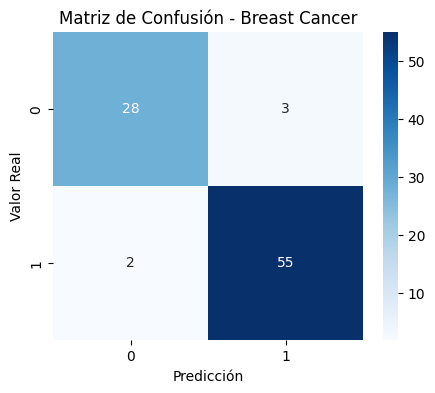


=== Breast Cancer | Self-Training ===

Resultados en Breast Cancer con SelfTrainingClassifier:
Accuracy: 0.6477, F1-score: 0.3931, Precision: 0.8239, Recall: 0.5000
Matriz de Confusión:
[[ 0 31]
 [ 0 57]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        31
           1       0.65      1.00      0.79        57

    accuracy                           0.65        88
   macro avg       0.82      0.50      0.39        88
weighted avg       0.77      0.65      0.51        88



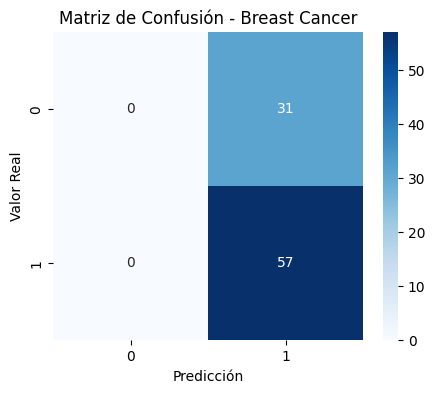

In [48]:
real_datasets = load_real_datasets(mask_ratio=0.5)

# Definir los métodos a comparar
models = {
    'Label Spreading': LabelSpreading(kernel='knn', n_neighbors=5, max_iter=50),
    'Self-Training':   SelfTrainingClassifier(SVC(probability=True, C=10, gamma=0.01), max_iter=50)
}

results = {}

# Evaluar cada dataset con cada modelo
for dataset_name, (X, y) in real_datasets.items():
    for model_name, model in models.items():
        print(f"\n=== {dataset_name} | {model_name} ===")
        metrics = evaluate_semi_supervised(model, X, y, dataset_name)
        results[(dataset_name, model_name)] = metrics

### Gráficas comparativas

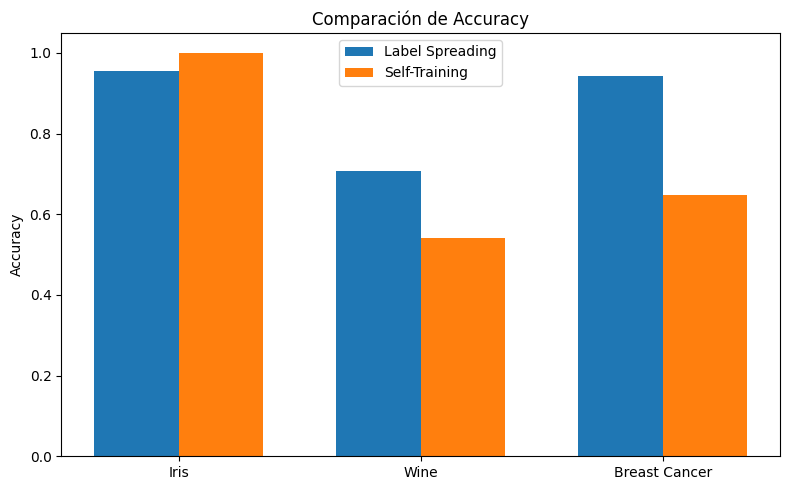

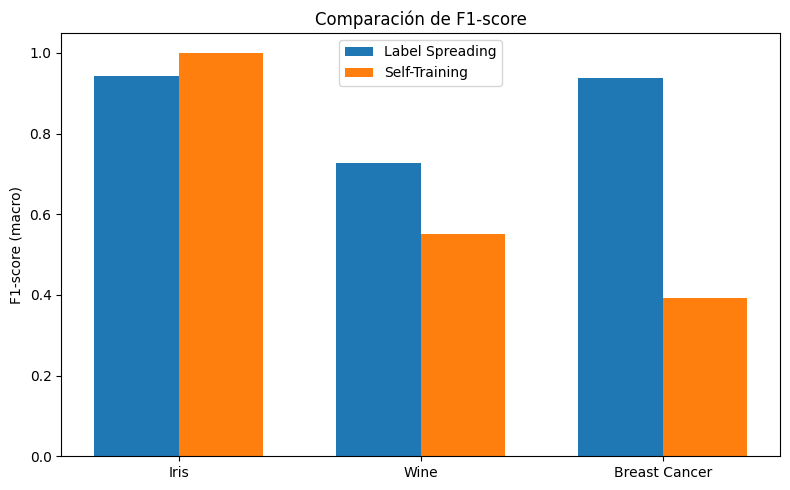

In [49]:
# Extraer los nombres de dataset
dataset_names = list(real_datasets.keys())
accuracies, f1_scores = [], []

for ds in dataset_names:
    acc_ls, f1_ls, _, _ = results[(ds, 'Label Spreading')]
    acc_st, f1_st, _, _ = results[(ds, 'Self-Training')]
    accuracies.append([acc_ls, acc_st])
    f1_scores.append([f1_ls, f1_st])

accuracies = np.array(accuracies)
f1_scores = np.array(f1_scores)
x = np.arange(len(dataset_names))
width = 0.35

# Comparación de Accuracy
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, accuracies[:, 0], width, label='Label Spreading')
ax.bar(x + width/2, accuracies[:, 1], width, label='Self-Training')
ax.set_ylabel("Accuracy")
ax.set_title("Comparación de Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(dataset_names)
ax.legend()
plt.tight_layout()
plt.show()

# Comparación de F1-score
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, f1_scores[:, 0], width, label='Label Spreading')
ax.bar(x + width/2, f1_scores[:, 1], width, label='Self-Training')
ax.set_ylabel("F1-score (macro)")
ax.set_title("Comparación de F1-score")
ax.set_xticks(x)
ax.set_xticklabels(dataset_names)
ax.legend()
plt.tight_layout()
plt.show()

## Discusión de Resultados

A modo de resumen, se pueden extraer algunas conclusiones tras los experimentos:

1. **Rendimiento de Label Spreading vs. Self-Training**  
   - En datasets donde la estructura de los datos favorece la propagación de etiquetas (por ejemplo, cuando las muestras de la misma clase están bien agrupadas), *Label Spreading* tiende a sobresalir.  
   - *Self-Training* depende en gran medida de la capacidad del clasificador base y de la elección del umbral de confianza. Con un buen modelo inicial (por ejemplo, un SVC ajustado) y un umbral adecuado, puede ser muy competitivo.

2. **Proporción de datos no etiquetados**  
   - En este caso, se ha utilizado un 50% de muestras etiquetadas y otro 50% sin etiqueta. Si la fracción de etiquetas reales disminuye aún más, suele empeorar el rendimiento de ambos métodos, aunque la magnitud de la degradación depende de la naturaleza del dataset.

3. **Variabilidad entre datasets**  
   - Cada dataset presenta desafíos distintos (número de características, balance de clases, separabilidad). *Iris* suele ser más sencillo y ambos métodos logran alta precisión.  
   - *Wine* y *Breast Cancer* pueden mostrar mayor complejidad, evidenciando diferencias en la capacidad de cada método para aprovechar los datos sin etiqueta.

En general, ambos métodos de aprendizaje semi-supervisado son útiles en escenarios con escasez de etiquetas. No obstante, la selección final puede basarse en la geometría del problema, las clases, el clasificador base y el ajuste de hiperparámetros (por ejemplo, número de vecinos en *Label Spreading*, umbral de confianza en *Self-Training*, etc.).